In [7]:
# import argparse
import os
import pickle
# import time
# from itertools import product
# from math import inf, pi

import jax
import jax.numpy as jnp
from jax.experimental.ode import odeint
import jax.debug as jdb
from functools import partial
import numpy as np

from tqdm.auto import tqdm

# from dynamics import prior, disturbance, plant
# from utils import params_to_posdef
from utils import random_ragged_spline, spline
from utils import (tree_normsq, rk38_step, epoch,   # noqa: E402
                   odeint_fixed_step, odeint_ckpt, random_ragged_spline, spline,
            params_to_cholesky, params_to_posdef, vee, hat,
            quaternion_to_rotation_matrix, flat_rotation_matrix_to_quaternion, 
            quaternion_multiply)

# from functools import partial
import matplotlib.pyplot as plt
# import csv

plt.rcParams.update({'font.size': 24})

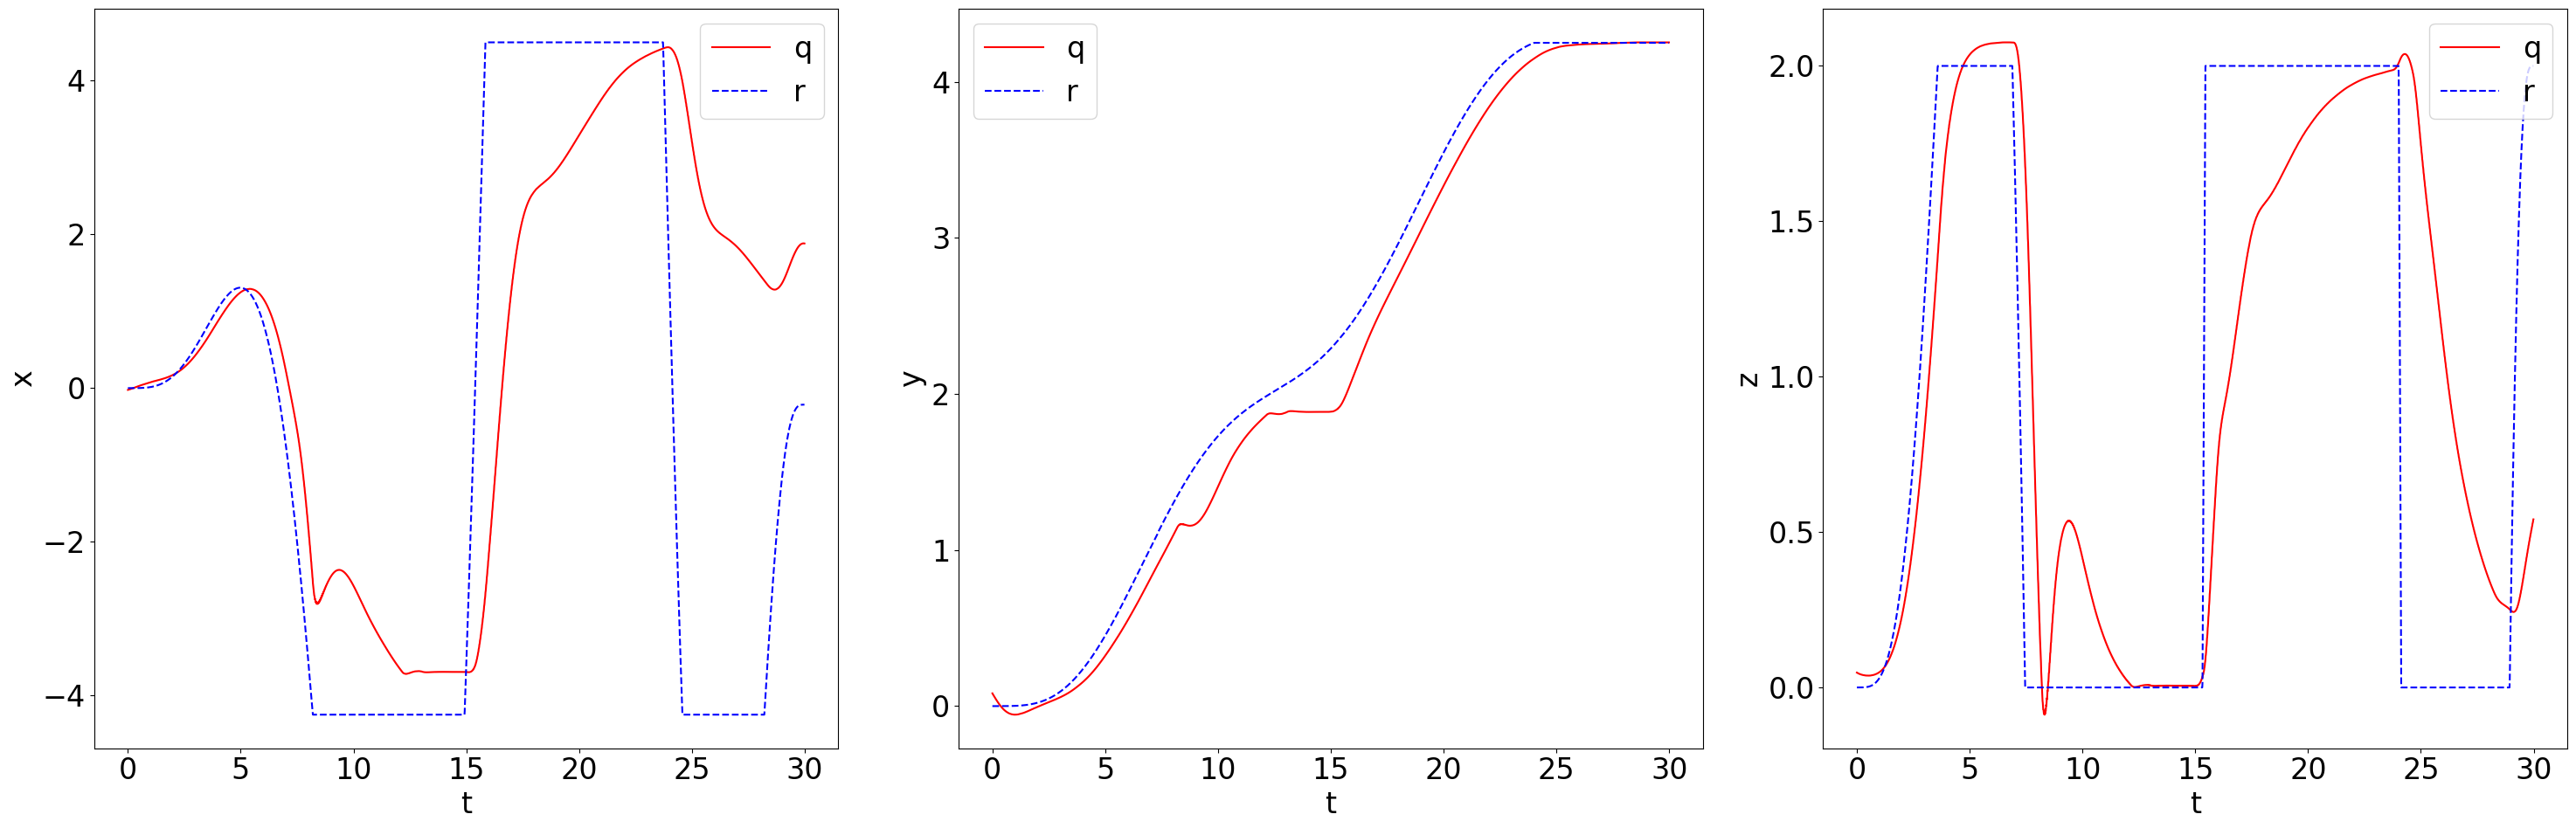

In [21]:
def plot_training_data(filename, traj=0):
    with open(f'data/{filename}', 'rb') as file:
        raw = pickle.load(file)

    num_traj = raw['q'].shape[0]       # total number of raw trajectories
    # ts = jnp.tile(raw['t'][:-1], (num_traj, 1))
    ts = raw['t'][:-1]
    q = raw['q'][traj, :-1]
    dq = raw['dq'][traj, :-1]
    r = raw['r'][traj, :-1]
    dr = raw['dr'][traj, :-1]
    u = raw['u'][traj, :-1, :3]
    quat = raw['quat'][traj, :-1]
    R = jax.vmap(quaternion_to_rotation_matrix, in_axes=0)(quat)
    R_flatten = R.reshape(R.shape[0], R.shape[1], -1)
    omega = raw['omega'][:, :-1]
    data = {'ts': ts, 'q': q, 'dq': dq, 'r': r, 'dr': dr, 'u': u, 'R_flatten': R_flatten, 'omega': omega}

    if os.path.exists('data/figs') == False:
        os.makedirs('data/figs')
        
    fig, ax = plt.subplots(1, 3, figsize=(30, 10))
    ax[0].plot(ts, data['q'][:, 0], 'r-', label='q')
    ax[0].plot(ts, data['r'][:, 0], 'b--', label='r')
    ax[0].set_ylabel('x')
    ax[0].set_xlabel('t')
    ax[0].legend()

    ax[1].plot(ts, data['q'][:, 1], 'r-', label='q')
    ax[1].plot(ts, data['r'][:, 1], 'b--', label='r')
    ax[1].set_ylabel('y')
    ax[1].set_xlabel('t')
    ax[1].legend()

    ax[2].plot(ts, data['q'][:, 2], 'r-', label='q')
    ax[2].plot(ts, data['r'][:, 2], 'b--', label='r')
    ax[2].set_ylabel('z')
    ax[2].set_xlabel('t')
    ax[2].legend()

    fig.tight_layout()
    # fig.savefig('data/figs/tracking_{}'.format(filename.replace('.pkl', '.png')))
    # plt.close(fig)

plot_training_data('2024-04-04_23-51-17_traj50_seed0.pkl', 30)
    

In [29]:
def generate_trajectory():
    # Seed random numbers
    seed = 0
    key = jax.random.PRNGKey(seed)

    xmin_ = -4.25
    xmax_ = 4.5
    ymin_ = -3.5
    ymax_ = 4.25
    zmin_ = 0.0
    zmax_ = 2.0

    # Generate smooth trajectories
    T = 30
    num_traj = 50
    num_knots = 6
    # poly_orders = (9, 9, 9, 6)
    poly_orders = (9, 9, 9)
    # deriv_orders = (4, 4, 4, 2)
    deriv_orders = (4, 4, 4)
    # min_step = jnp.array([-2., -2., 0, -jnp.pi/6])
    min_step = jnp.array([-2., -2., -0.75])
    # max_step = jnp.array([2., 2., 2., jnp.pi/6])
    max_step = jnp.array([2., 2., 0.75])
    # min_knot = jnp.array([xmin_, ymin_, zmin_, -jnp.pi/3])
    min_knot = jnp.array([xmin_, ymin_, zmin_])
    # max_knot = jnp.array([xmax_, ymax_, zmax_, jnp.pi/3])
    max_knot = jnp.array([xmax_, ymax_, zmax_])

    key, *subkeys = jax.random.split(key, 1 + num_traj)
    subkeys = jnp.vstack(subkeys)
    in_axes = (0, None, None, None, None, None, None, None, None)
    t_knots, knots, coefs = jax.vmap(random_ragged_spline, in_axes)(
        subkeys, T, num_knots, poly_orders, deriv_orders,
        min_step, max_step, min_knot, max_knot
    )
    r_knots = jnp.dstack(knots)

    # Sampled-time simulator
    @partial(jax.vmap, in_axes=(None, 0, 0))
    def simulate(ts, t_knots, coefs):
        """TODO: docstring."""
        # Construct spline reference trajectory
        def reference(t):
            x_coefs, y_coefs, z_coefs = coefs
            x = spline(t, t_knots, x_coefs)
            y = spline(t, t_knots, y_coefs)
            z = spline(t, t_knots, z_coefs)
            x = jnp.clip(x, xmin_, xmax_)
            y = jnp.clip(y, ymin_, ymax_)
            z = jnp.clip(z, zmin_, zmax_)
            r = jnp.array([x, y, z])
            return r

        # Required derivatives of the reference trajectory
        def ref_derivatives(t):
            ref_vel = jax.jacfwd(reference)
            ref_acc = jax.jacfwd(ref_vel)
            r = reference(t)
            dr = ref_vel(t)
            ddr = ref_acc(t)
            return r, dr, ddr

        # Simulation loop
        def loop(carry, input_slice):
            t_prev = carry
            t = input_slice

            r, dr, ddr = ref_derivatives(t)
            carry = (t)
            output_slice = (r, dr, ddr)
            return carry, output_slice

        # Initial conditions
        t0 = ts[0]
        r0, dr0, ddr0 = ref_derivatives(t0)
        
        # Run simulation loop
        carry = (t0)
        carry, output = jax.lax.scan(loop, carry, ts[1:])
        r, dr, ddr = output

        # Prepend initial conditions
        r = jnp.vstack((r0, r))
        dr = jnp.vstack((dr0, dr))
        ddr = jnp.vstack((ddr0, ddr))

        return r, dr, ddr
    
    dt = 0.01
    t = jnp.arange(0, T + dt, dt)  # same times for each trajectory
    r, dr, ddr = simulate(t, t_knots, coefs)
    return t, r, dr, ddr

ts, r, dr, ddr = generate_trajectory()

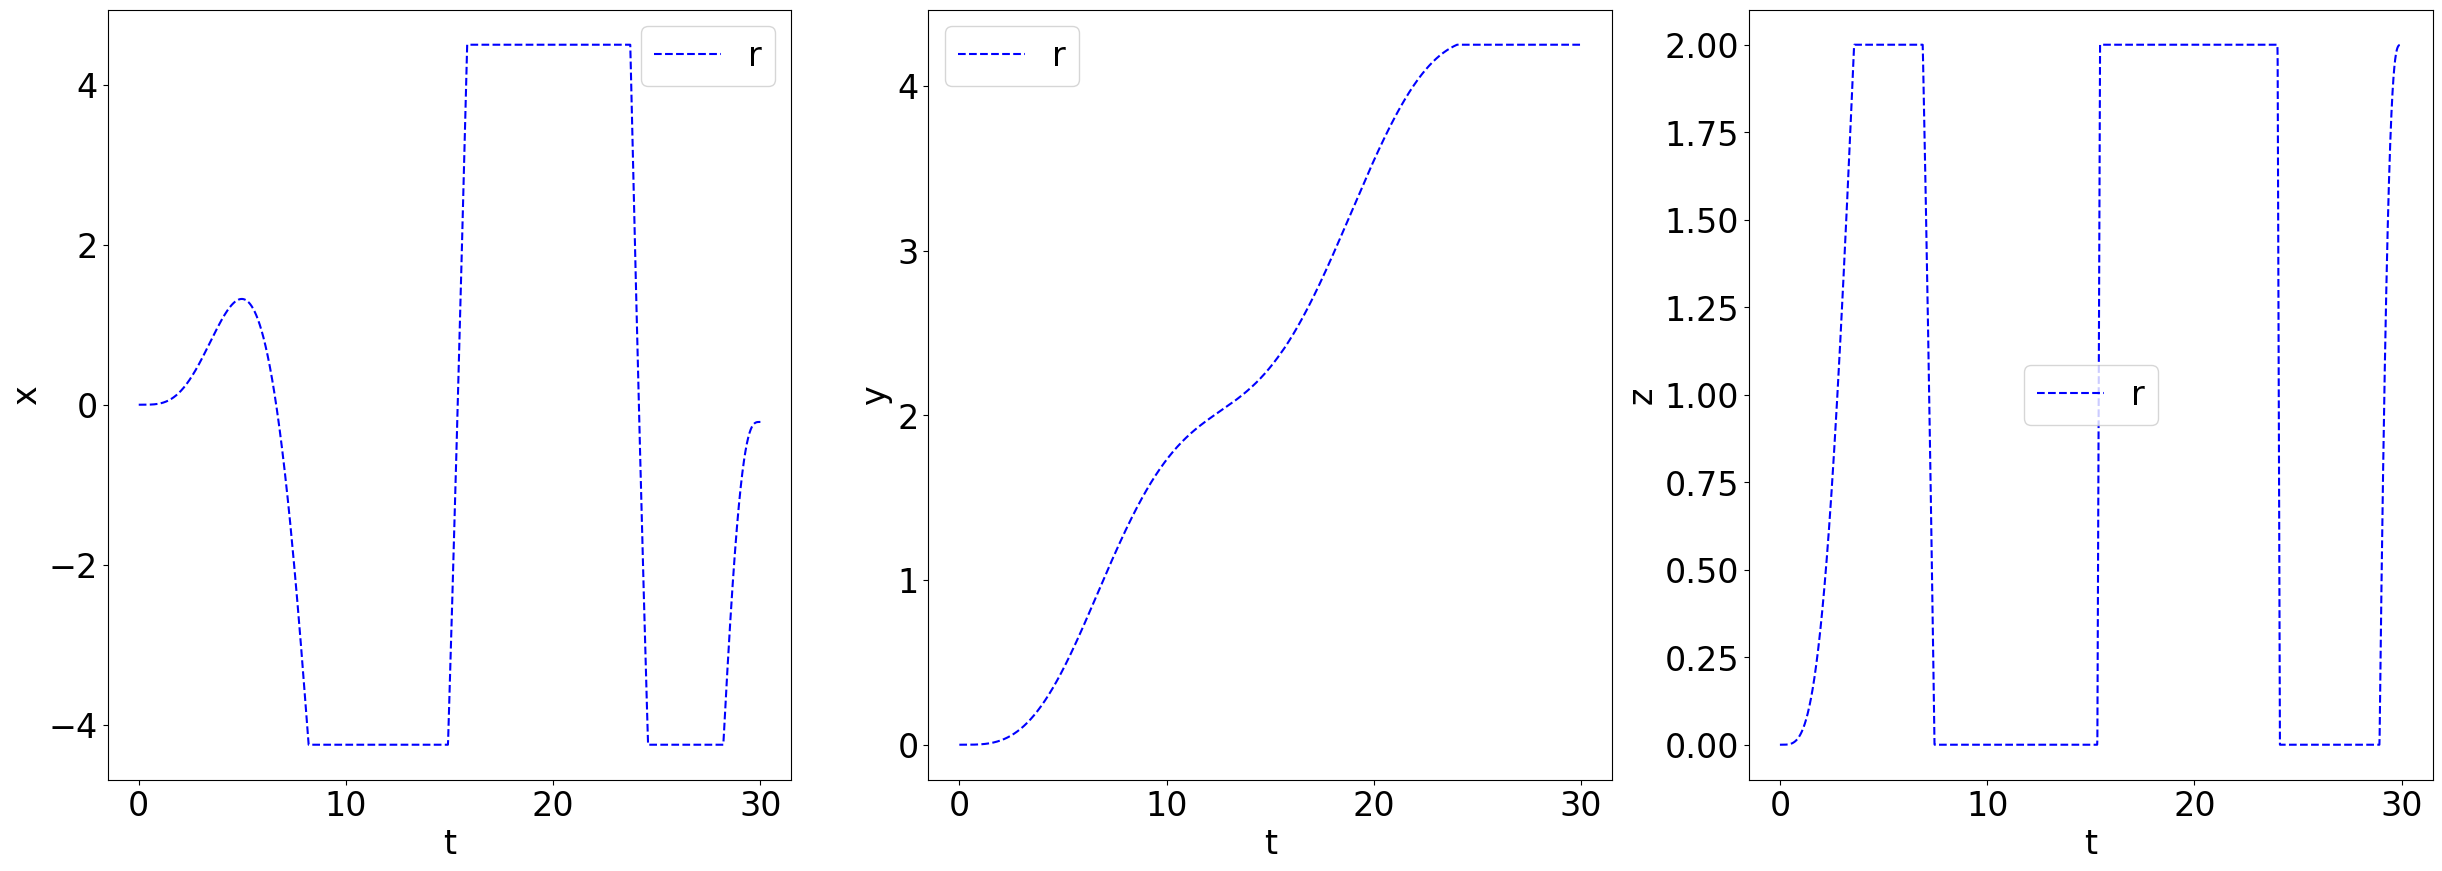

In [30]:
def plot_r(ts, r, traj=0):
    fig, ax = plt.subplots(1, 3, figsize=(30, 10))
    ax[0].plot(ts, r[traj, :, 0], 'b--', label='r')
    ax[0].set_ylabel('x')
    ax[0].set_xlabel('t')
    ax[0].legend()

    ax[1].plot(ts, r[traj, :, 1], 'b--', label='r')
    ax[1].set_ylabel('y')
    ax[1].set_xlabel('t')
    ax[1].legend()

    ax[2].plot(ts, r[traj, :, 2], 'b--', label='r')
    ax[2].set_ylabel('z')
    ax[2].set_xlabel('t')
    ax[2].legend()

plot_r(ts, r, 5)